In [138]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd

import seaborn as sns
from __future__ import division
import time
from cvxpy import *

from distutils.log import error
import errno
import numpy as np
import pandas as pd
import time
from datetime import date
import cvxpy as cp

import parameters

In [139]:
User_PV_Data = pd.read_csv('./Solar_Demand.csv')

# get_all_values gives a list of rows.


userdata = np.array(User_PV_Data.values)


print(User_PV_Data)

     Time  PV_Output  PV_Percentage  Demand_kW  Grid_Cost
0    0:00        0.0            0.0       0.12       0.01
1    0:15        0.0            0.0       0.12       0.01
2    0:30        0.0            0.0       0.12       0.01
3    0:45        0.0            0.0       0.12       0.01
4    1:00        0.0            0.0       0.16       0.01
..    ...        ...            ...        ...        ...
763   NaN        0.0            0.0       0.20       0.01
764   NaN        0.0            0.0       0.16       0.01
765   NaN        0.0            0.0       0.16       0.01
766   NaN        0.0            0.0       0.16       0.01
767   NaN        0.0            0.0       0.16       0.01

[768 rows x 5 columns]


In [140]:
prof=pd.Series(dtype='object')

prof.loc['Solar']=User_PV_Data.iloc[:, 1]
prof.loc['Load']=User_PV_Data.iloc[:, 3]
prof.loc['Price']=User_PV_Data.iloc[:, 4]*100

N=prof.Load.shape[0]

In [141]:
prof.Load

0      0.12
1      0.12
2      0.12
3      0.12
4      0.16
       ... 
763    0.20
764    0.16
765    0.16
766    0.16
767    0.16
Name: Demand_kW, Length: 768, dtype: float64

In [142]:
net = prof.Load-prof.Solar
# split load into +ve and -ve
posLoad = np.copy(net)
negLoad = np.copy(net)
for j,e in enumerate(net):
    if e>=0:
        negLoad[j]=0
    else:
        posLoad[j]=0
posLoadDict = dict(enumerate(posLoad))
negLoadDict = dict(enumerate(negLoad))

In [143]:
import pyomo.environ as pyo

In [144]:
m = pyo.ConcreteModel()

m.Time = pyo.Set(initialize=pyo.RangeSet(N),ordered=True)

#scalar parameters
m.Kpv = pyo.Param(initialize=.03) # Solar capacity cost ($/kW)
m.Kb = pyo.Param(initialize= .25) # Battery capacity cost ($/kWh)
m.VCC = pyo.Param(initialize= 75) # Battery discharge cost ($/MWh)
m.nu =pyo.Param(initialize= 0.85) # Battery efficiency
m.r = pyo.Param(initialize= 0.004) # Real interest rate
m.b_min_cap = pyo.Param(initialize= 0) # min battery cap

#time indexed parameters
m.grid_cost = pyo.Param(m.Time,initialize=dict(enumerate(prof.Price,1)),within=pyo.Any)
m.demand = pyo.Param(m.Time,initialize=dict(enumerate(prof.Load,1)),within=pyo.Any)
m.solar = pyo.Param(m.Time,initialize=dict(enumerate(prof.Solar,1)),within=pyo.Any)
m.negLoad = pyo.Param(m.Time, initialize=dict(enumerate(negLoad,1)), within=pyo.Any)
m.posLoad = pyo.Param(m.Time, initialize=dict(enumerate(posLoad,1)), within=pyo.Any)

In [145]:
#time indexed Variables
m.SOC= pyo.Var(m.Time, domain=pyo.NonNegativeReals, initialize=0) # Battery state of charge at step k (MWh)
m.Bc = pyo.Var(m.Time, initialize=0) # Battery charge at step k (MWh)
m.Bd = pyo.Var(m.Time, initialize=0, domain=pyo.NonNegativeReals) # Battery dischcharge at step k (MWh)
m.Gi = pyo.Var(m.Time, initialize = dict(enumerate(posLoad,1)), domain=pyo.NonNegativeReals) # Grid energy import at step k (MWh)
m.Ge = pyo.Var(m.Time, initialize = dict(enumerate(negLoad,1)), domain=pyo.NonNegativeReals) 
m.Dpv = pyo.Var(m.Time, domain=pyo.NonNegativeReals) # Curtailed PV production at step k (MWh)
m.Dl =pyo.Var(m.Time, domain=pyo.NonNegativeReals) # Cutailed load at step k (MWh)
m.X =pyo.Var(m.Time, initialize=0, domain=pyo.NonNegativeReals) # Solar capacity MW
m.Y = pyo.Var(m.Time, initialize=0, domain=pyo.NonNegativeReals) # Battery capacity MWh


In [146]:
#CONSTRAINTS
#Purchase constraint
def purchase_constraint(m,k):
    return m.Gi[k] == m.demand[k] - m.Bd[k] + m.Bc[k] - m.X[k]*m.solar[k] + m.Ge[k]

def panel_constraint(m,k):
    if m.solar[k]>0:
        return m.X[k]*m.solar[k]>= 1
    else:
        return pyo.Constraint.Skip

#State of charge constraint
def soc_constraint(m,k):
    m.SOC[1]==m.Y[1]
    if k<=95:
        return (m.SOC[k+1]==m.SOC[k] + m.Bc[k]*m.nu - m.Bd[k]*m.nu)
    else:
        return (m.SOC[k]==m.SOC[k] + m.Bc[k]*m.nu - m.Bd[k]*m.nu)
    
#Discharge and charge constraints
def discharge_constraint_1(m,k):
    """ Maximum discharge rate within time set k"""
    return m.Bd[k] <= m.Y[k]/4

def discharge_constraint_2(m,k):
    """ Sets the maximum energy available to be discharged as the SOC - minimum SOC """
    return m.Bd[k] <= m.SOC[k] 

def charge_constraint_1(m,k):
    """ Maximum charge rate within a single hour """
    return m.Bc[k] <= m.Y[k]/4

def charge_constraint_2(m,k):
    """ Sets the maximum energy available to be cahrge as the SOC max """
    return m.Bc[k]  <= m.Y[k] - m.SOC[k]


    solver failure.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2867.76799999999
  Upper bound: 2867.76799999999
  Number of objectives: 1
  Number of constraints: 5081
  Number of variables: 5081
  Number of nonzeros: 12655
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.1474015712738037
# ----------------------------------------------------------
#   Solution 

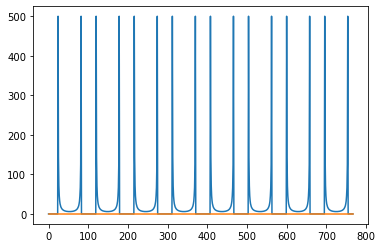

In [147]:
#constraints
m.Gi_c = pyo.Constraint(m.Time, rule = purchase_constraint)
m.SOC_c = pyo.Constraint(m.Time, rule = soc_constraint)
m.Bd_c1 = pyo.Constraint(m.Time, rule = discharge_constraint_1)
m.Bd_c2 = pyo.Constraint(m.Time,rule = discharge_constraint_2)
m.Bc_c1 = pyo.Constraint(m.Time,rule = charge_constraint_1)
m.Bc_c2 = pyo.Constraint(m.Time,rule = charge_constraint_2)
m.X_c = pyo.Constraint(m.Time,rule = panel_constraint)

#OBJECTIVE 
m.objective = pyo.Objective(expr = sum([(m.Gi[k].value*m.grid_cost[k] +m.X[k].value*m.Kpv/N + m.Y[k].value*m.Kb/N) for k in m.Time]), sense = pyo.minimize)   
 
opt = pyo.SolverFactory('glpk')
results = opt.solve(m)
results.write()
 
x=[pyo.value(m.X[1])]
y=[pyo.value(m.Y[1])]

for t in m.Time:
    if t < N:
        x.append(pyo.value(m.X[t+1]))
        y.append(pyo.value(m.Y[t+1]))
plt.plot(x)
plt.plot(y)

